In [1]:
import numpy as np
import time
import cv2
import os 
import shutil
import matplotlib.pyplot as plt 

Model used is YOLOv4. YOLOv4 was trainrf using Darknet Framework. Training was done using this car_damage_yolo_training_colab.ipynb in google colab

Download this [zip file](https://drive.google.com/file/d/1AtLw0qOJn2wItyWYVYWBQvf8-OBmdwDo/view?usp=sharing) containing weights and cfg and extract the files to yolo folder

In [2]:
INPUT_FILE = os.listdir("./input_images/")
LABELS_FILE='./yolo/obj.names'
CONFIG_FILE='./yolo/custom-yolov4-detector.cfg'
WEIGHTS_FILE='./yolo/custom-yolov4-detector_last.weights'
CONFIDENCE_THRESHOLD=0.3

LABELS = open(LABELS_FILE).read().strip().split("\n")

np.random.seed(4)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)

[INFO] YOLO took 0.370011 seconds


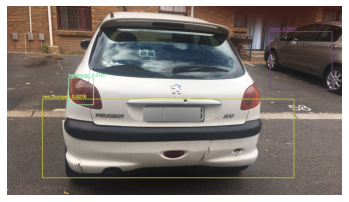

[INFO] YOLO took 0.221407 seconds


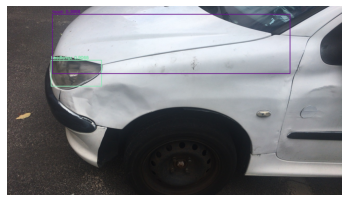

[INFO] YOLO took 0.218894 seconds


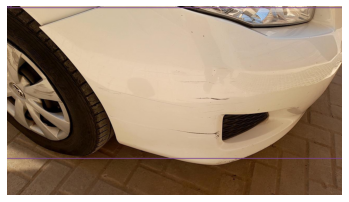

[INFO] YOLO took 0.231353 seconds


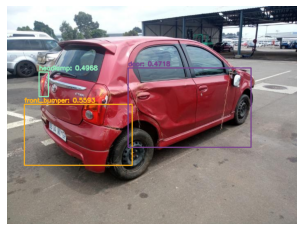

[INFO] YOLO took 0.219413 seconds


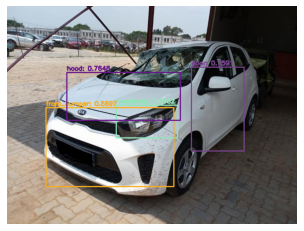

In [3]:
for img_file in INPUT_FILE:
    path = os.path.join("./input_images/",img_file)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    (H, W) = image.shape[:2]


    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]


    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()


    print("[INFO] YOLO took {:.6f} seconds".format(end - start))

    boxes = []
    confidences = []
    classIDs = []
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions
            if confidence > CONFIDENCE_THRESHOLD:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    # Non-max supression
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,
        CONFIDENCE_THRESHOLD)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[classIDs[i]]]

            image = cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            image = cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, color, 2)

    # show the output image
    plt.imshow(image)
    plt.axis('off')
    plt.show()